<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/HUPV/notebooks/solutions/cv03_en_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 - Linear Classifier, Gradient Optimization

In this lab we will implement a simple linear classifier on synthetic 2D data.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

## Synthetic data

For the purposes of this lab, we will first work with synthetic data. We will generate them by assuming that the 2D data are from two normal distributions, while each of the two distributions corresponds to one class.

We will generate both training data and test data.

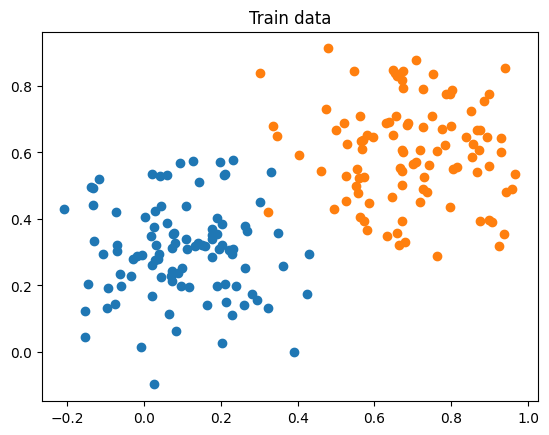

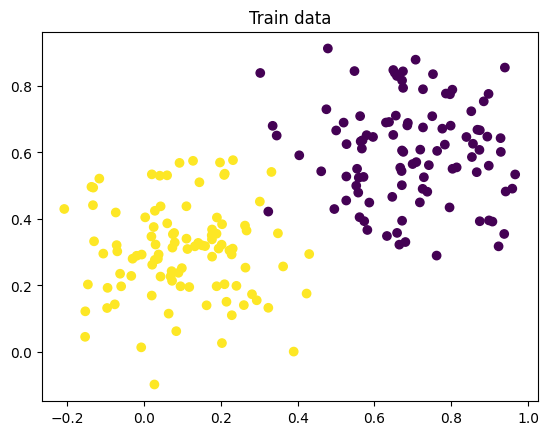

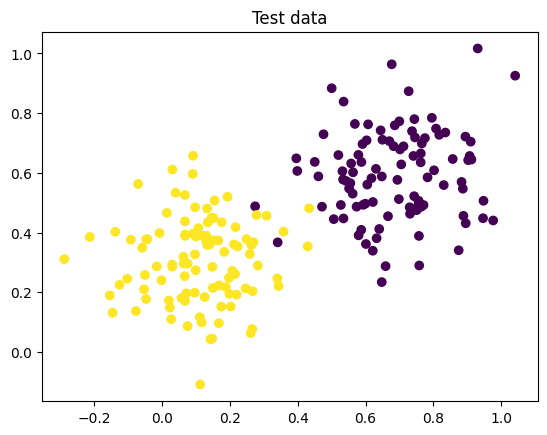

In [ ]:
np.random.seed(11)

x1_center = np.array([0.1, 0.3])
x1 =  x1_center + 0.15 * np.random.randn(100, 2)

x2_center = np.array([0.7, 0.6])
x2 =  x2_center + 0.15 * np.random.randn(100, 2)

# while the classes are separated they are easy to plot
plt.scatter(x1[:, 0], x1[:, 1])
plt.scatter(x2[:, 0], x2[:, 1])
plt.title("Train data")
plt.show()

# we will modify the data to have vector x with data and y with labels
y = np.ones(200)
y[100:] = -1
x = np.concatenate([x1, x2], axis=0)

# we will also randomly permute the data
pindxs = np.random.permutation(200)
x = x[pindxs]
y = y[pindxs]

plt.scatter(x[:, 0], x[:, 1], c=y)
plt.title("Train data")
plt.show()

# we will also generate the test data
x1_test = x1_center + 0.15 * np.random.randn(100, 2)
x2_test =  x2_center + 0.15 * np.random.randn(100, 2)
y_test = np.ones(200)
y_test[100:] = -1
x_test = np.concatenate([x1_test, x2_test], axis=0)
pindxs = np.random.permutation(200)
x_test = x_test[pindxs]
y_test = y_test[pindxs]

plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.title("Test data")
plt.show()

## Linear binary classifier

First, we will make the simplest so-called binary linear classifier.

We can perceive this classifier as a function $f: \mathbb{R}^n \mapsto \{-1, 1\}$. The input is the so-called feature vector. At the moment we will work with vectors from $\mathbb{R}^2$, so the input is represented by 2 real numbers. The output will be 1 if we classify the given vector as the first (positive) class and -1 if we classify the given input as the second (negative) class.

So the function $f$ is a classifier, but we don't yet know exactly what $f$ will look like. The classifier will have the form of:

$$ f = \text{sgn}(\vec{w}^T \vec{x} + b) = \text{sgn}\left(\sum_{i=1}^n w_i \cdot x_i + b\right),$$

where $\vec{w} \in \mathbb{R}^n$ (in our case $n = 2$), $b \in \mathbb{R}$ and $\text{sgn}$ is the signum function, which is defined as 1 for numbers higher than or equal to 0 and -1 otherwise. So we have a vector of weights $\vec{w}$ and bias $b$, which are the parameters of our model. Our goal will be to find $\vec{w}, b$ so that our classifier works as well as possible.

### Exercise 1 - Prediction

Implement the function which for the given parameters $\vec{w}$ and $b$ for the provided data. We want to return both the predicted classes and the accuracy, which is expressed as the proportion of correctly classified inputs.

To visualize the classifier, you can use the provided function that displays the straight line that divides the plane.


In [ ]:
def display_binary_cls(x, y, w, b):
  if x.shape[1] != 2:
    raise TypeError("x has to represent 2-d points of shape (n, 2)")
  if y.shape[0] != x.shape[0]:
    raise TypeError("x and y have to have same number of rows")
  if w.shape[0] != 2:
    raise TypeError("w has to be an array of shape (2,) ")

  xmin = np.min(x[:, 0])
  xmax = np.max(x[:, 0])
  ymin = np.min(x[:, 1])
  ymax = np.max(x[:, 1])

  plt.xlim(xmin=xmin - 0.1, xmax=xmax + 0.1)
  plt.ylim(ymin=ymin - 0.1, ymax=ymax + 0.1)


  if w[1] == 0.0:
    plt.plot([-b / w[0], -b / w[0]], [ymin, ymax], c='black')
  else:

    ymin = (- w[0] * xmin - b) / w[1]
    ymax = (- w[0] * xmax - b) / w[1]

    plt.plot([xmin, xmax], [ymin, ymax], c='black')

  plt.scatter(x[:, 0], x[:, 1], c=y)
  plt.show()

Implement the `binary_cls(x, w, b)` function, which will have input data x and model parameters $\vec{w}$ and $b$ as input. At the output, it returns an array y, which will contain the classes as -1 or 1.

In [ ]:
def binary_cls(x, w, b):
  y = np.where(np.dot(x, w) + b > 0, 1, -1)
  return y

Test the function on the manually selected parameters, which should give quite good accuracy (above 90 percent).

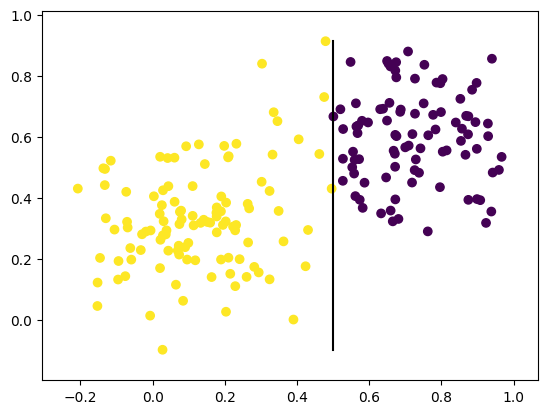

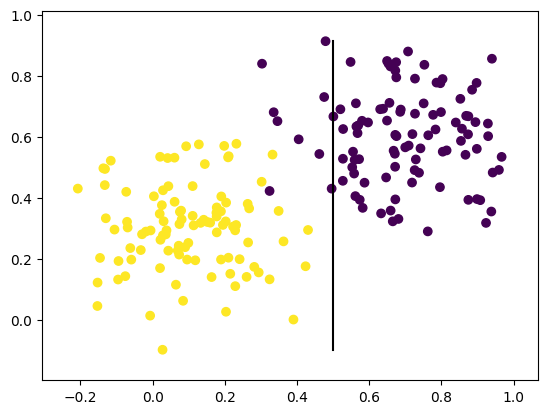

Accuracy of classifier:  0.955


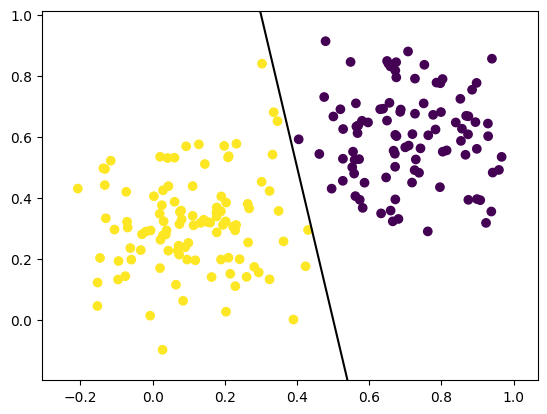

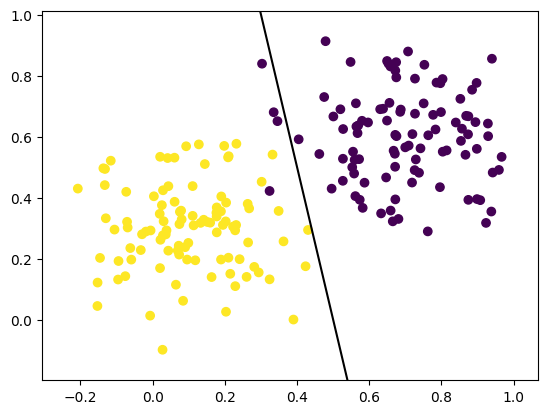

Accuracy of classifier:  0.98


In [ ]:
w = np.array([-1.0,0.0])
b = 0.5

y_pred = binary_cls(x, w, b)
display_binary_cls(x, y_pred, w, b)
display_binary_cls(x, y, w, b)

acc = np.sum(y_pred == y)/len(y)
print("Accuracy of classifier: ", acc)

w = np.array([-1.0, -0.2])
b = 0.5

y_pred = binary_cls(x, w, b)
display_binary_cls(x, y_pred, w, b)
display_binary_cls(x, y, w, b)

acc = np.sum(y_pred == y)/len(y)
print("Accuracy of classifier: ", acc)

### Exercise 2 - Training

Manually estimated parameters are fine for 2D data, but it would be ideal to estimate them automatically, in a process in which the machine learns them (hence machine learning). We transform this problem into a standard optimization task. We will look for the parameters $\vec{w}$ and $b$ so as to minimize some function $L(\vec{w}, b, X, \vec{Y})$, where $X = (\vec{x}_1, \vec{x}_2,~...~\vec{x}_m)$ represents the input data and $\vec{Y} = (y_1, y_2,~...,~y_m)$ the annotations.

$L$ is also called a loss function and it can have different shapes. Today we will use this:

$$L(\vec{w}, b, X, \vec{Y}) = \frac{1}{m} \sum_{i = 1}^m \text{max}\left(0, 1 - y_i \left( \vec{w}^T \vec{x}_i + b\right)\right)$$

In order to find the optimal parameters, we will use gradient descent. It consists in the fact that we will estimate the parameters $\vec{w}$ and $b$ iteratively by first determining the random parameters and adjusting them based on the rules:

$$b^{n + 1} = b^n - \eta \frac{\partial L}{\partial b}(\vec{w}^n, b^n, X, \vec{Y})$$

$$w_j^{n + 1} = w_j^n - \eta \frac{\partial L}{\partial w_j}(\vec{w}^n, b^n, X, \vec{Y})$$,

where $\eta is the so-called step size. Of course we need to know the gradients:

$$\frac{\partial L}{\partial b}(\vec{w}_j^n, b^n, X, \vec{Y}) = \frac{1}{m} \sum_{i = 1}^m -z_i^n y_i,$$
$$\frac{\partial L}{\partial w_j}(\vec{w}_j^n, b^n, X, \vec{Y}) = \frac{1}{m} \sum_{i = 1}^m -z_i^n y_i x_{i, j},$$

where $x_{i, j}$ is the $j$-th component of the $i$-th vector from the training set X and

$$z_i^n = \begin{cases} 1,~if~\left(\vec{w}^{nT} \vec{x}_i + b\right) y_i < 1 \\ 0,~otherwise \end {cases}$$

Write a function `train_binary_cls(x, y, w_init, b_init, eta)` which will have $X, \vec{Y}, \vec{w}^0, b^0, \eta$ and the number of iteration steps $n$ as input and output returns $\vec{w}^n$ and $b^n$. In addition, it prints the value of the loss function at every hundredth step.

### Bonus exercise

As a bonus, you can try to derive gradients and implement them in the case when our loss function would also contain a regularization term, so:

$$L(\vec{w}, b, X, Y) = \frac{1}{m} \sum_{i = 1}^m \text{max}\left(0, 1 - y_i \left( \vec{w}^T \vec{x}_i + b\right)\right) + \lambda \sum_{i=1}^2 w_i^2$$

Then add the $\lambda$ parameter as an argument to the `train_binary_cls` function.

In [ ]:
def train_binary_cls(x, y, w, b, eta, n):
  m = len(y)
  for i in range(n):
    if i % 100 == 0:
      loss = np.mean(np.clip(1 - (np.sum(w[np.newaxis, :] * x, axis=-1) + b) * y, 0.0, np.inf))
      print("At step {} loss: {}".format(i, loss))

    z = np.where((np.dot(x, w) + b) * y < 1, 1, 0)
    b -= eta/m * np.sum(-z * y)
    w[0] -= eta/m * np.sum(-z * y * x[:, 0])
    w[1] -= eta/m * np.sum(-z * y * x[:, 1])

  return w, b

We can test the code.



At step 0 loss: 1.074400979741701
At step 100 loss: 0.9768745668938247
At step 200 loss: 0.9183557493079431
At step 300 loss: 0.8630225347711392
At step 400 loss: 0.8088860971227231
At step 500 loss: 0.7553136587807119
At step 600 loss: 0.7018070466989224
At step 700 loss: 0.6485332647474178
At step 800 loss: 0.5952815772030314
At step 900 loss: 0.5420299267751758
At step 1000 loss: 0.48882695163693013
At step 1100 loss: 0.43566609553502905
At step 1200 loss: 0.384110452457046
At step 1300 loss: 0.34016929750627267
At step 1400 loss: 0.3065643989055752
At step 1500 loss: 0.27957765237568477
At step 1600 loss: 0.25558231180574736
At step 1700 loss: 0.23453370102083898
At step 1800 loss: 0.21914966101029898
At step 1900 loss: 0.2069879094493008
At step 2000 loss: 0.1963507697301243
At step 2100 loss: 0.18754689022912277
At step 2200 loss: 0.18018877971660935
At step 2300 loss: 0.17361939535698034
At step 2400 loss: 0.16767605226831953
At step 2500 loss: 0.16192966186048682
At step 2600 l

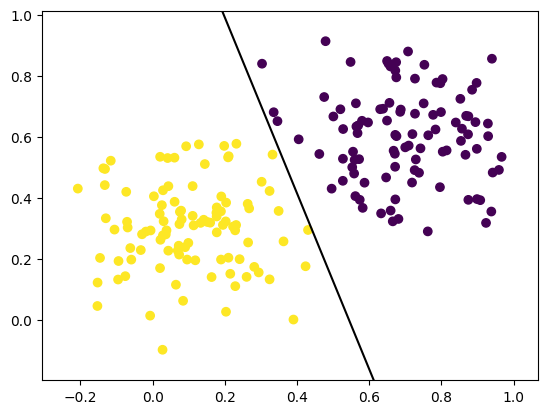

Accuracy of classifier on training data:  0.995


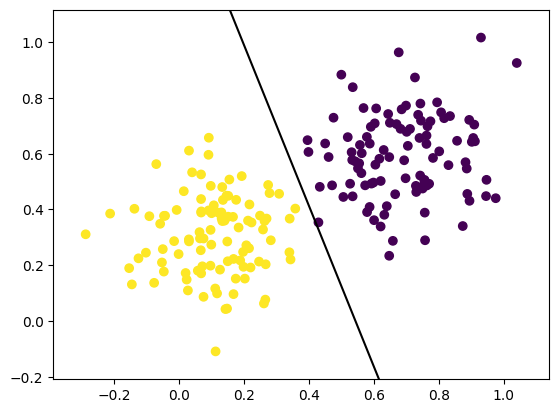

Accuracy of classifier on test data data:  0.98


In [ ]:
w_train, b_train = train_binary_cls(x, y, np.array([0.0, 0.5]), -1.0, 1e-2, 5000)
print(w_train, b_train)

y_pred = binary_cls(x, w_train, b_train)
display_binary_cls(x, y_pred, w_train, b_train)
acc = np.sum(y_pred == y)/len(y)
print("Accuracy of classifier on training data: ", acc)


y_pred_test = binary_cls(x_test, w_train, b_train)
display_binary_cls(x_test, y_pred_test, w_train, b_train)
acc_test = np.sum(y_pred_test == y_test)/len(y)
print("Accuracy of classifier on test data data: ", acc_test)

## Pytorch - automatic gradients

With a simple linear classifier, we knew how to implement gradients for the purpose of optimization by hand. Of course, it would be more difficult for more complicated models. Therefore, we will now see how it is possible to use the PyTorch framework and calculate the gradient automatically.

At its core, PyTorch operates on tensors very similarly to NumPy. However, PyTorch additionally calculates intermediate calculations so that gradients can be calculated and is also optimized for GPU calculations. In addition, the framework is very "pythonic", which can generally be considered an advantage.

In [ ]:
import torch
from torch.autograd import Variable

A tensor can be created from numpy using `torch.from_numpy`, or via the `torch.Tensor` constructor. Similarly, variables can be created. It is often necessary to pay attention to the type that the given vector has. It can be retyped using the type method. Sometimes, however, it is enough to retype it directly into numpy.

In [ ]:
a = torch.from_numpy(np.array([4, 6, 7, 9]))
print(a)
print(a.shape)
print(a.type())
b = torch.from_numpy(np.array([[4, 6, 7, 9], [1, 1, 1, 1] ]))
print(b)
print(b.shape)
print(b.type())
bb = b.type(torch.FloatTensor)
print(bb.type())


c = torch.from_numpy(np.array([[4, 6, 7, 9], [1, 1, 1, 1] ], dtype=np.float32))
print(c)
print(c.shape)
print(c.type())

d = torch.Tensor([1,0,4])
print(d)
print(d.type())

e = torch.Tensor([1,0,4]).type(torch.LongTensor)
print(e)
print(e.type())

tensor([4, 6, 7, 9])
torch.Size([4])
torch.LongTensor
tensor([[4, 6, 7, 9],
        [1, 1, 1, 1]])
torch.Size([2, 4])
torch.LongTensor
torch.FloatTensor
tensor([[4., 6., 7., 9.],
        [1., 1., 1., 1.]])
torch.Size([2, 4])
torch.FloatTensor
tensor([1., 0., 4.])
torch.FloatTensor
tensor([1, 0, 4])
torch.LongTensor


It is also possible to convert back mainly using the `numpy()` method.


In [ ]:
dn = d.numpy()
print(dn)
print(type(dn))
print(dn.shape)

[1. 0. 4.]
<class 'numpy.ndarray'>
(3,)


Like a numpy array, a torch Tensor can also be indexed. If we have a tensor with only one element, we can get it using the `item` method.

In [ ]:
r = torch.from_numpy(np.random.rand(10, 4, 5))


print(r[0, 0, 0])
print(r[:, 1])
print(r[1:3, :, 0])
print(r[::2, 0, 1:4])

print(r[0, 0, 0].item())
print(type(r[0, 0, 0]))
print(type(r[0, 0, 0].item()))


tensor(0.0974, dtype=torch.float64)
tensor([[0.6323, 0.7324, 0.5328, 0.9185, 0.0697],
        [0.3859, 0.4914, 0.7534, 0.2725, 0.8514],
        [0.6957, 0.7258, 0.6996, 0.9706, 0.8613],
        [0.3766, 0.7910, 0.1675, 0.2539, 0.5375],
        [0.4619, 0.8787, 0.7478, 0.0297, 0.1948],
        [0.4273, 0.5912, 0.6343, 0.4327, 0.8512],
        [0.4796, 0.5718, 0.0427, 0.9734, 0.8586],
        [0.2165, 0.7318, 0.0751, 0.7804, 0.5254],
        [0.4423, 0.2371, 0.7308, 0.9499, 0.8423],
        [0.0468, 0.8886, 0.2325, 0.2100, 0.0064]], dtype=torch.float64)
tensor([[0.5752, 0.3859, 0.9189, 0.6061],
        [0.3751, 0.6957, 0.5232, 0.6622]], dtype=torch.float64)
tensor([[0.1374, 0.4940, 0.6875],
        [0.7878, 0.2281, 0.8697],
        [0.8157, 0.6389, 0.7300],
        [0.0800, 0.2401, 0.5659],
        [0.6258, 0.2123, 0.3753]], dtype=torch.float64)
0.09743909439945198
<class 'torch.Tensor'>
<class 'float'>


If we want to use the model of our classifier, we first create its variables. The forward function then returns the result before the signum function is applied.

We can test the model on some data. If we only want to make a prediction, then we have to let torch know that we don't need it to store the intermediate calculations for the gradient computation. Note that the inputs to the function are torch tensors. So a tensor is something on which torch can perform operations.

*Note:* Since we want to use vector operations, we assume that we will always input vectors in the form $N \times 2$, but $N$ can also be 1.

In [ ]:
w = Variable(torch.randn(2).type(torch.FloatTensor), requires_grad=True)
b = Variable(torch.randn(1).type(torch.FloatTensor), requires_grad=True)

def forward(x, w, b):
  return torch.tensordot(w, x, dims=[[0], [1]]) + b

def predict(x, w, b):
  return torch.where(forward(x, w, b) > 0.0, 1, -1)

with torch.no_grad():
  print(forward(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)), w, b))
  print(forward(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w, b))
  print(forward(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w, b))

  print(predict(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)), w, b))
  print(predict(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w, b))
  print(predict(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w, b))

tensor([2.1658])
tensor([1.6889])
tensor([4.3229])
tensor([1])
tensor([1])
tensor([1])


We can implement training very simply. First, we calculate the loss function. This will be a torch tensor and we can call its `backward` method, which will calculate the gradient for all intermediate steps.

At step: 0 loss: 1.6724733114242554
At step: 100 loss: 1.212459683418274
At step: 200 loss: 0.9987120032310486
At step: 300 loss: 0.888551652431488
At step: 400 loss: 0.7783903479576111
At step: 500 loss: 0.6682289838790894
At step: 600 loss: 0.5583548545837402
At step: 700 loss: 0.4498075842857361
At step: 800 loss: 0.37945711612701416
At step: 900 loss: 0.33430930972099304
At step: 1000 loss: 0.30075013637542725
At step: 1100 loss: 0.27313342690467834
At step: 1200 loss: 0.25073930621147156
At step: 1300 loss: 0.2321254014968872
At step: 1400 loss: 0.2169666439294815
At step: 1500 loss: 0.20427487790584564
At step: 1600 loss: 0.1933252364397049
At step: 1700 loss: 0.18387241661548615
At step: 1800 loss: 0.17552118003368378
At step: 1900 loss: 0.1687212586402893
At step: 2000 loss: 0.1630202680826187
At step: 2100 loss: 0.15745338797569275
At step: 2200 loss: 0.15239131450653076
At step: 2300 loss: 0.14772464334964752
At step: 2400 loss: 0.14329956471920013
At step: 2500 loss: 0.13911

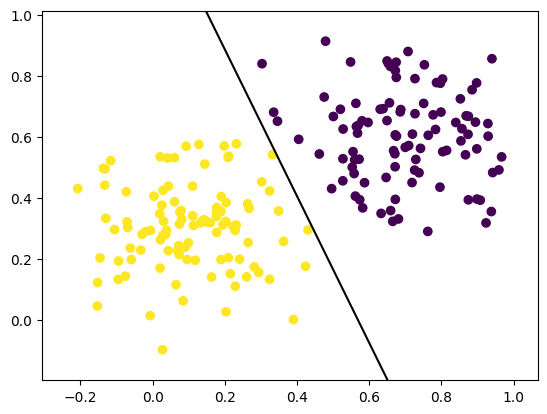

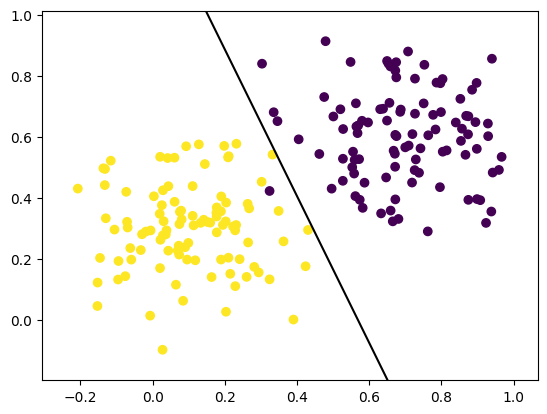

In [ ]:
def train_torch_binary_cls(x, y, w, b, eps, n):
  x = torch.from_numpy(x).type(torch.FloatTensor)
  y = torch.from_numpy(y).type(torch.FloatTensor)

  for i in range(n):

    out = forward(x, w, b)
    loss = torch.mean(torch.clip(1 - out * y, min=0.0))

    if i % 100 == 0:
      print("At step: {} loss: {}".format(i, loss.item()))

    # we calculate the gradients
    loss.backward()

    # we perform the gradient update
    w.data -= eps * w.grad.data
    b.data -= eps * b.grad.data

    # now we have to reset the gradient as otherwise they would keep accumulating
    w.grad.data.zero_()
    b.grad.data.zero_()
  return w, b

w_trained, b_trained = train_torch_binary_cls(x, y, w, b, 1e-2, 5000)

y_pred = predict(torch.from_numpy(x).type(torch.FloatTensor), w, b).numpy()

display_binary_cls(x, y_pred, w.detach().numpy(), b.detach().numpy())
display_binary_cls(x, y, w.detach().numpy(), b.detach().numpy())


### Exercise 3 - Different loss function

The loss function we have used so far is not the only possible one. A suitable candidate is also the so-called binary cross entropy. In order to use it, we slightly modify the output from the classifier so that the output returns the probability that the given vector is from the first class, i.e. $f_p : \mathbb{R}^n \mapsto [0,1]$ and its form will be:

$$ f_p = \sigma \left(\vec{w}^T \vec{x} + b\right) = \sigma \left(\sum_{i=1}^n w_i x_i + b\right) = \sigma \left(z\right), $$ while the function $\sigma$ is defined as:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

and when drawn it looks like this:

![plot of sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1920px-Logistic-curve.svg.png)

So it returns values from 0 to 1 and $y = \sigma (z) = \sigma(\vec{w}^T \vec{x} + b)$ so we can interpret it as the probability that the given vector $\vec{x }$ belongs to the positive class. Based on this interpretation, we can then use the binary cross-entropy as the loss function (binary cross-entropy):

$$L(\vec{w}, b, X, \vec{Y}) = -\frac{1}{m} \sum_{i = 1}^m y_i \text{log}\left(\sigma(\vec{ w}^T \vec{x}_i + b)\right) + (1 - y_i) \text{log}\left(1 - \sigma(\vec{w}^T \vec{x}_i + b )\right),$$

where $\vec{w}$ and $b$ are model parameters, $X$ is a $m \times n$ matrix that contains a vector from the training set on each row, and $\vec{Y}$ is a vector of classes, **but this time the first class will be marked as 1 and the second class as 0** (zero probability that the given element is from the first class).

So, implement the forward_bce, predict_bce and train_bce functions according to the structure as in the code above.

In [ ]:
w = Variable(torch.randn(2).type(torch.FloatTensor), requires_grad=True)
b = Variable(torch.randn(1).type(torch.FloatTensor), requires_grad=True)

# we generate new data
y_bce = np.where(y > 0.0, 1.0, 0.0)

def sigmoid(z):
  return 1 / (1 + torch.exp(-z))

def forward_bce(x, w, b):
  return sigmoid(torch.tensordot(w, x, dims=[[0], [1]]) + b)

def predict_bce(x, w, b):
  return torch.where(forward(x, w, b) > 0.5, 1, 0)

with torch.no_grad():
  print(forward_bce(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)), w, b))
  print(forward_bce(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w, b))
  print(forward_bce(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w, b))

  print(predict_bce(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)), w, b))
  print(predict_bce(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w, b))
  print(predict_bce(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w, b))

tensor([0.4776])
tensor([0.4581])
tensor([0.5784])
tensor([0])
tensor([0])
tensor([0])


At step: 0 loss: 0.7351498603820801
At step: 100 loss: 0.7108660340309143
At step: 200 loss: 0.6887572407722473
At step: 300 loss: 0.6682066321372986
At step: 400 loss: 0.6488839983940125
At step: 500 loss: 0.6306027770042419
At step: 600 loss: 0.6132485866546631
At step: 700 loss: 0.5967434644699097
At step: 800 loss: 0.5810283422470093
At step: 900 loss: 0.5660542845726013
At step: 1000 loss: 0.5517781376838684
At step: 1100 loss: 0.5381605625152588
At step: 1200 loss: 0.5251652002334595
At step: 1300 loss: 0.512757420539856
At step: 1400 loss: 0.5009050369262695
At step: 1500 loss: 0.4895772933959961
At step: 1600 loss: 0.4787454307079315
At step: 1700 loss: 0.4683821201324463
At step: 1800 loss: 0.4584616720676422
At step: 1900 loss: 0.44896000623703003
At step: 2000 loss: 0.43985411524772644
At step: 2100 loss: 0.43112266063690186
At step: 2200 loss: 0.4227454364299774
At step: 2300 loss: 0.41470351815223694
At step: 2400 loss: 0.4069790244102478
At step: 2500 loss: 0.399555206298

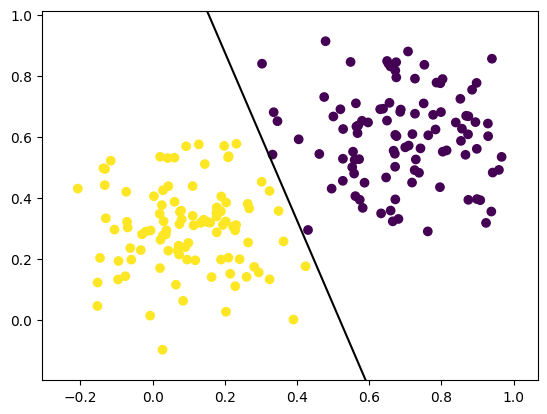

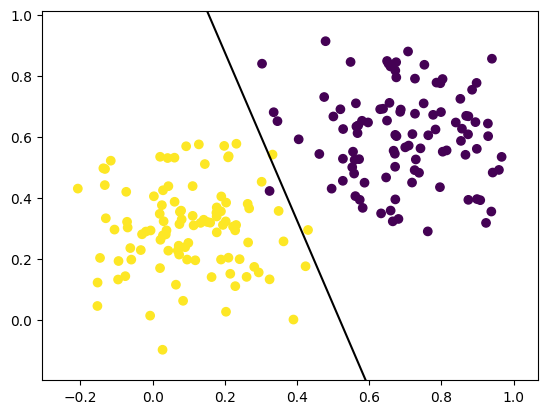

In [ ]:
def train_torch_binary_cls(x, y, w, b, eps, n):
  x = torch.from_numpy(x).type(torch.FloatTensor)
  y = torch.from_numpy(y).type(torch.FloatTensor)

  for i in range(n):

    out = forward_bce(x, w, b)
    loss = - torch.mean(y * torch.log(out) + (1 - y) * torch.log(1 - out))

    if i % 100 == 0:
      print("At step: {} loss: {}".format(i, loss.item()))

    # we calculate the gradients
    loss.backward()

    # we perform the gradient update
    w.data -= eps * w.grad.data
    b.data -= eps * b.grad.data

    # then we have to reset the gradients
    w.grad.data.zero_()
    b.grad.data.zero_()


train_torch_binary_cls(x, y_bce, w, b, 1e-2, 5000)
train_torch_binary_cls(x, y_bce, w, b, 1e-3, 5000)

y_pred = predict(torch.from_numpy(x).type(torch.FloatTensor), w, b).numpy()

display_binary_cls(x, y_pred, w.detach().numpy(), b.detach().numpy())
display_binary_cls(x, y, w.detach().numpy(), b.detach().numpy())

### Bonus Exercise

Those who have finished everything can make a fully connected neural network instead of an ordinary linear classifier. For example if we add one more hidden layer, we get:

$$f_{c} = \sigma\left(\vec{w}_{out}^T \vec{\sigma}\left(W_{in} \vec{x} + \vec{b}_{in }\right) + b_{out}\right),$$

where $W_{in} \in \mathbb{R}^{h \times 2}$ is the $h \times 2$ weight matrix, $\vec{b}_{in} \in \mathbb{R}^{ h}$ is the bias vector applied after the first matrix, $w_{out} \in \mathbb{R}^{h}$ is the vector of weights with length $h$ and $b_{out} \mathbb{R}$ is the bias parameter, where $h$ is the number of hidden layer neurons and $\vec{\sigma}$ is the sigma function applied to each element of the vector separately.

If you manage to implement the function, you can try to add the regularization term for the weight vector and the weight matrix again. Thus, the loss will have the form:

$$L(\vec{w}, b, X, \vec{Y}) = -\frac{1}{m} \sum_{i = 1}^m y_i \text{log}\left(\sigma(\vec{ w}^T \vec{x}_i + b)\right) + (1 - y_i) \text{log}\left(1 - \sigma(\vec{w}^T \vec{x}_i + b )\right) + \lambda \left(\sum_{i, j} W_{in,i,j}^2 + \sum_{i} w_{out,i}^2 \right)$$

In [ ]:
w_out = Variable(torch.randn(30).type(torch.FloatTensor), requires_grad=True)
b_out = Variable(torch.randn(1).type(torch.FloatTensor), requires_grad=True)

w_in = Variable(torch.randn(30, 2).type(torch.FloatTensor), requires_grad=True)
b_in = Variable(torch.randn(30).type(torch.FloatTensor), requires_grad=True)

# we generate labels
y_fc = np.where(y > 0.5, 1.0, 0.0)


def sigmoid(z):
  return 1 / (1 + torch.exp(-z))

def forward_fc(x, w_in, b_in, w_out, b_out):
  x = sigmoid(torch.matmul(x, w_in.T) + b_in)
  return sigmoid(torch.tensordot(w_out, x, dims=[[0], [1]]) + b_out)

def predict_fc(x, w_in, b_in, w_out, b_out):
  return torch.where(forward_fc(x, w_in, b_in, w_out, b_out) > 0.5, 1, 0)

with torch.no_grad():
  print(forward_fc(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)),  w_in, b_in, w_out, b_out))
  print(forward_fc(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w_in, b_in, w_out, b_out))
  print(forward_fc(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w_in, b_in, w_out, b_out))

  print(predict_fc(torch.from_numpy(np.array([[0.5, 0.5]], dtype=np.float32)), w_in, b_in, w_out, b_out))
  print(predict_fc(torch.from_numpy(np.array([[1.0, -0.5]], dtype=np.float32)), w_in, b_in, w_out, b_out))
  print(predict_fc(torch.from_numpy(np.array([[-0.9, 4.4]], dtype=np.float32)), w_in, b_in, w_out, b_out))

def train_torch_binary_fc(x, y, w_in, b_in, w_out, b_out, eps, n):
  x = torch.from_numpy(x).type(torch.FloatTensor)
  y = torch.from_numpy(y).type(torch.FloatTensor)

  for i in range(n):

    out = forward_fc(x, w_in, b_in, w_out, b_out)
    loss = - torch.mean(y * torch.log(out) + (1 - y) * torch.log(1 - out))

    if i % 100 == 0:
      print("At step: {} loss: {}".format(i, loss.item()))

    loss.backward()

    w_in.data -= eps * w_in.grad.data
    b_in.data -= eps * b_in.grad.data
    w_out.data -= eps * w_out.grad.data
    b_out.data -= eps * b_out.grad.data

    w_in.grad.data.zero_()
    b_in.grad.data.zero_()
    w_out.grad.data.zero_()
    b_out.grad.data.zero_()
  return w_in, b_in, w_out, b_out

train_torch_binary_fc(x, y_fc, w_in, b_in, w_out, b_out, 1e-2, 5000)
train_torch_binary_fc(x, y_fc, w_in, b_in, w_out, b_out, 1e-3, 5000)

y_pred = predict_fc(torch.from_numpy(x).type(torch.FloatTensor), w_in, b_in, w_out, b_out,).numpy()

print(np.sum(y_pred == y_fc)/len(y_fc))

#display_binary_cls(x, y_pred, w.detach().numpy(), b.detach().numpy())
#display_binary_cls(x, y, w.detach().numpy(), b.detach().numpy())

tensor([0.1042])
tensor([0.0641])
tensor([0.2742])
tensor([0])
tensor([0])
tensor([0])
At step: 0 loss: 1.5482505559921265
At step: 100 loss: 0.950165331363678
At step: 200 loss: 0.8319126963615417
At step: 300 loss: 0.7388429045677185
At step: 400 loss: 0.6616042852401733
At step: 500 loss: 0.597130298614502
At step: 600 loss: 0.5429428219795227
At step: 700 loss: 0.49705255031585693
At step: 800 loss: 0.4578801989555359
At step: 900 loss: 0.4241776764392853
At step: 1000 loss: 0.39495906233787537
At step: 1100 loss: 0.36944305896759033
At step: 1200 loss: 0.3470076024532318
At step: 1300 loss: 0.32715460658073425
At step: 1400 loss: 0.30948227643966675
At step: 1500 loss: 0.2936643362045288
At step: 1600 loss: 0.2794339060783386
At step: 1700 loss: 0.2665712237358093
At step: 1800 loss: 0.25489380955696106
At step: 1900 loss: 0.24424946308135986
At step: 2000 loss: 0.2345101684331894
At step: 2100 loss: 0.22556783258914948
At step: 2200 loss: 0.21733039617538452
At step: 2300 loss: 0